# Black Box Optimisation
## Introduction
This notebook showcases the `sumomo` package enabling surrogate modelling and optimisation of black box models. To begin, ensure that this notebook directory is in the system path and then proceed to import the *Application Programming Interface* `api` from `sumomo` which enables the interface between the package frameworks and black box models. Also import the various utility and plotting functions from `utils` such as the `peaks` function used as an example black box function used in this notebook.

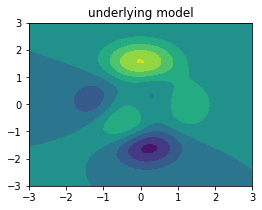

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

import torch
from torch import nn

from sumomo import API
from utils import peaks, plot_peaks, plot_sampling, plot_model


plot_peaks()

## Initialise

Use `api.initialise` to produce an initial set of statis samples and initialised output variable and target arrays. The `initialise` method requires input attributes `n_samples` and `input_space` where the former is the total number of input samples to generate and the latter is the search space defined by lower and upper bounds on each dimension. If the number of outputs to be sampled is greater than 1 (default), `n_outputs` can be specified. Finally, the sampling strategy to be used can be defined with the `method` attribute. The default sampling strategy is Latin Hypercube Sampling `lhs` with a *maximin* criterion to maximise the minimal pairwise distance between samples. Implementations of LHS and Sobol sampling from `skopt` are available in addition to grid sampling and random sampling methods.

Here, 100 input samples are generated for 2 input variables each bounded between (-3.0, 3.0) using LHS. A 1 dimensional output vector is initialised as well as the target vector. Output vectors are intialised with zero values as the default to represent an unsampled output whilst also existing at the mean after standardisation of the data. The target data is intialised as ones as the default representing converged simulations, enabling the framework to be used without feasibility constraints in the default case.

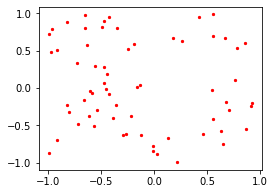

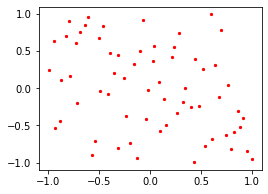

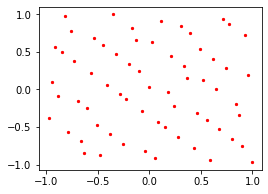

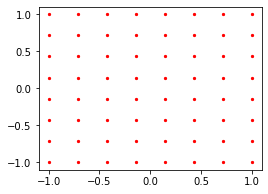

In [2]:
n = 64
for strategy in ['random', 'lhs', 'sobol', 'grid']:
    api = API(n, [(-1.0, 1.0), (-1.0, 1.0)], 1, strategy)
    plot_sampling(api)

In [3]:
api = API(n_samples=100, space=[(-3.0, 3.0), (-3.0, 3.0)], n_outputs=1, method='lhs')

print(api.x)
print(api.y)
print(api.t)

[[ 0.52175239  0.82541932]
 [-2.42389222 -2.95794165]
 [-2.20224429  1.05691103]
 [ 1.19117089 -0.07854923]
 [-1.66389535  2.81335968]
 [-1.9670013  -0.52710669]
 [ 1.21076645 -1.65281463]
 [-1.49832583 -2.90842451]
 [ 0.88209304 -2.17416303]
 [ 2.97466265 -0.61073164]
 [ 0.03824568  0.52239427]
 [-2.7271726  -2.72215264]
 [ 0.58560154  2.53165633]
 [-2.90206186 -0.66252509]
 [ 2.8874047   2.3196057 ]
 [-2.61108548  0.59824367]
 [ 0.13346254  2.99814517]
 [-2.23093228  0.00740339]
 [-0.98277004 -2.04971961]
 [ 1.63149468  2.22760546]
 [-0.03546644  1.01392317]
 [-0.42317551  2.70252221]
 [ 1.7926508   0.06618392]
 [ 0.45532028 -2.49959793]
 [ 2.57699338  1.39723672]
 [-1.26823108  1.76378912]
 [ 0.20345947  2.64783502]
 [ 2.1379962  -0.76452612]
 [-1.87948396 -0.24530365]
 [ 2.46374957 -0.13739546]
 [-1.8154051   0.2627164 ]
 [-1.9933691  -1.48533882]
 [ 0.9947471   2.84114512]
 [-0.84554365 -0.55206673]
 [ 1.36560893 -1.86195225]
 [-0.6435376   0.46779381]
 [-2.12694013 -0.38481353]
 

## Sampling

The API provides the initialised output and target arrays, but it is necessary to script the population of these empty arrays with the sampled black box data manually. This is due to different black box models and simulations having different Python interfacing capabilities. Typically, one input sample is sent to the black box to be evaluated, so this is simulated here using a `for` loop to iterate over the input samples one-by-one. For each input sample `x[i]`, a corresponding output `y[i]` is evaluated along with a binary target `t[i]` representing a converged sample (1) or non-converged sample (0). The peaks function is used as the black box to generate input-output data. Feasible designs (i.e. converged or `t=1`) are constrained to within a circle with radius 2 (or infeasible designs are defined as those outside this circles boundary since `t` is 1 by default) for demonstrative purposes. When sampling from black box simulations in practice, there is typically a black box variable which defines the convergence enabling the user to explicitly sample target data.

In [4]:
for i in range(api.x.shape[0]):
    if ( api.x[i, 0] ** 2 + api.x[i, 1] ** 2 > 4 ):
        api.t[i] = 0

api.y = peaks(api.x)

print(api.y)
print(api.t)

[[ 1.62381809e+00]
 [ 1.06005124e-03]
 [-2.50773736e-01]
 [ 3.50036921e+00]
 [ 3.93374155e-02]
 [-8.05900373e-01]
 [-1.60349668e+00]
 [ 4.48586421e-03]
 [-1.94984697e+00]
 [ 2.67977639e-02]
 [ 4.24572713e-01]
 [ 6.51079181e-04]
 [ 1.21593109e+00]
 [-3.08233309e-02]
 [ 9.99699847e-04]
 [-1.45656902e-01]
 [ 2.96926449e-01]
 [-7.29701571e-01]
 [-6.18775913e-01]
 [ 2.87620454e-01]
 [ 3.86210079e+00]
 [ 8.11134674e-01]
 [ 2.18705735e+00]
 [-1.45776526e+00]
 [ 4.06702495e-02]
 [ 1.35111387e+00]
 [ 1.12587748e+00]
 [ 5.61938741e-01]
 [-1.45768436e+00]
 [ 3.35034605e-01]
 [-1.92366597e+00]
 [ 8.02668392e-02]
 [ 2.15718274e-01]
 [ 2.09467726e+00]
 [-9.42705756e-01]
 [-2.27571297e-01]
 [-7.23839440e-01]
 [ 3.94196766e+00]
 [ 2.82507128e-01]
 [-6.48883385e-02]
 [-4.11017981e-01]
 [ 2.90402530e+00]
 [ 1.22365066e-03]
 [ 4.28214700e+00]
 [ 5.39692975e-01]
 [-9.33084778e-01]
 [ 6.38974482e+00]
 [ 3.56529206e-01]
 [ 2.89779714e+00]
 [-2.17854339e-01]
 [ 2.10702551e-01]
 [ 1.38769832e-02]
 [-2.3977483

## Data processing

Before using data `x, y, t` to train surrogate models, any train-test-splits and appropriate scaling must be used (in this order - split then scale).

### Train-test-split

The `split` method can be used to partition the `x, y, t` data into training and testing sets, `x_train, y_train, t_train` and `x_test, y_test, t_test`. This enables users to train the surrogate models using most of the sampled data whilst witholding some data from the model to be used to test the trained model performance without necessitating further sampling from the expensive black box. The `split` method takes the parameter `test-size` enabling the user to decide what fraction of the data to withold for testing purposes (default is 0.3).

In [5]:
api.split(test_size=0.3)

print(api.x_train.shape)

(70, 2)


### Standardisation

It is important that prior to training surrogate models, the input-output data is scaled appropriately. Specifically, scaling over the samples, for each dimension, ensures that variables with large magnitudes do not have a greater influence on measures of surrogate model fit which would result in overfitting to specific dimensions at the cost of overall model accuracy.

The scaling method uses standarisation to subtract the mean and divide the result by the standard deviation so that each dimension follows a normal distribution with mean 0 and a standard deviation of 1. When the data is not split beforehand, `x` is simply standardised over the entire dataset to generate `x_` and the `api` object also saves the `x_mean` and `x_std` values for future scaling and descaling purposes. Here, `x_mean` and `x_std` are used to scale the `space` paramter to provide bounds of the scaled search space as `space_`. In this case, `y` is standardised using the `y_mean` and `y_std` of only the converged output data to produce `y_`.

It is important to split and then scale the data so that training data is scaled using only the training data and not the full data set. For the input data, this case produces `x_train_`, whilst `x_train_mean` and `x_train_std` values are used to standarise `x_test_` into the same scaled space as the training data which was used to train the surrogate model. In this case, `space_` is also generated using `x_train_mean` and `x_train_std`. Similarly, `y_train_` and `y_test_` are both standarised using `y_train_mean` and `y_train_std` of converged training outputs only.

In [6]:
api.scale()

print(api.y_train_mean, api.y_train_std)

[0.60491525] [2.46456778]


## Regressor model training

The `init_regressor` method can be used to fit a regression surrogate model to the scaled input-output data. This methods recieves a parameter `type` as a string to define whether to use a Gaussian Process Regressor `gp` or a Neural Network `nn`. In addition, the user can pass keyword arguments to define the setup of the particular model. For example, for a NN, the user must specify parameters `hidden_layers` as a list of number of nodes in each hidden layer (e.g. `hidden_layers=[10, 10]`) and `activation` as a string to define the activation function applied to each hidden layer. Activation functions available are `tanh`, `sigmoid`, `softplus`, and `relu`. For a GP model users can specify a level of `noise`.

To train the surrogate model the user uses the relevant methods provided by the model object interfaced through `api.regressor`. It should be noted that the regressor models are typically fitted to standardised input-output data or standardised training data using `api.regressor.fit(api.x_, api.y_)` or `api.regressor.fit(api.x_train_, api.y_train_)` respectively.

In [7]:
api.init_regressor('nn', hidden_layers=[15, 5], activation='tanh')
api.regressor.fit(api.x_train_, api.y_train_)

print(api.regressor)

NN(
  (0): Linear(in_features=2, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=5, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


## Classifier model training

The `init_classifier` method can be used to fit a classification surrogate model to the scaled input data and binary target data. This methods also recieves a parameter `type` as a string to define whether to use a Gaussian Process Classifier `gp` or a Neural Network `nn`. The user passes keyword arguments to define the setup of the model in the same way as for regression models. NNs recieve the same parameters `hidden_layers` and `activation` whereas GPs do not have any customisable parameters. Activation functions available for classification are `sigmoid`or `hardsigmoid` where these function are applied to hidden layers and the output layer in the classification case.

To train the surrogate model the user uses the relevant methods provided by the model object interfaced through `api.classifier`. The classifier is typically trained using scaled input data and target data or the training equivalents using `api.classifier.fit(api.x_, api.t)` or `api.classifier.fit(api.x_train_, api.t_train)`, respectively.

In [8]:
api.init_classifier('nn', hidden_layers=[10], activation='sigmoid')
api.classifier.fit(api.x_train_, api.t_train, loss_func=nn.BCEWithLogitsLoss())

print(api.classifier)

NN(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


## Pyomo formulations

### Foundations

The `api` provided by `sumomo` enables the optimisation formualations of trained surrogate models to be plugged into larger optimisation formulations where required. To show this, begin initialising an optimisation problem saved as `opt`. This optimisation problem has variables `inputs` with the same dimensions as our surrogate model inputs, a scalar `output` variable, and a scalar variable `feasibility`. Here, also define a constraint for this larger optimisation formulation that the feasibility probability must be greater than 0.5. Finally, define the objective function as maximise `output`.

In [9]:
opt = pyo.ConcreteModel()

opt.n_inputs = set(range(api.x.shape[1]))

opt.inputs = pyo.Var(opt.n_inputs, bounds=api.space_)
opt.output = pyo.Var()
opt.logits = pyo.Var()

opt.feasibility_con = pyo.Constraint(expr= 1 / (1 + pyo.exp(-opt.logits)) >= 0.5 )

opt.obj = pyo.Objective(expr=opt.output, sense=pyo.maximize)

opt.pprint()

1 Set Declarations
    inputs_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}

3 Var Declarations
    inputs : Size=2, Index=inputs_index
        Key : Lower               : Value : Upper              : Fixed : Stale : Domain
          0 :  -1.738045076306188 :  None :  1.696354638499446 : False :  True :  Reals
          1 : -1.6940050482051585 :  None : 1.7420191229516715 : False :  True :  Reals
    logits : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  None :  None : False :  True :  Reals
    output : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  None :  None : False :  True :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize :     output

1 Constraint Declarations
    feasibil

### Formulating surrogate model constraints

The constraints defining the relationship between `output` and `inputs` will be enforced by the regression surrogate model, whilst the constraints defining the relationship between `feasibility` and `inputs` will be enforced by the classifier surrogate model. To achieve this, simply use the `formulate` method provided by the `api` and pass in the trained surrogate model instance for which to formulate constraints. Assign the output of this method call to an attribute of the larger optimisation problem where the surrogate model formulation will be contained as a Pyomo *Block*. Finally, connect the optimisation problem variables `inputs` and `output` to the surrogate model input and output variables.

In [10]:
opt.mdl = api.formulate(api.regressor)
opt.feas = api.formulate(api.classifier)

# connect pyomo model input and output to the surrogate models
@opt.Constraint(opt.n_inputs)
def connect_regressor_inputs(m, i):
    return m.inputs[i] == m.mdl.inputs[i]

@opt.Constraint(opt.n_inputs)
def connect_classifier_inputs(m, i):
    return m.inputs[i] == m.feas.inputs[i]

@opt.Constraint()
def connect_regressor_output(m):
    return m.output == m.mdl.outputs[0]

@opt.Constraint()
def connect_classifier_output(m):
    return m.logits == m.feas.outputs[0]

### Solving the optimisation problem

The user must then define the solver and desired solver settings before writing the solve statement.

In [11]:
# solver setup
solver = pyo.SolverFactory('baron')
solver.options['MaxTime'] = 30

# macOS requires CplexLibName option to be specified, please change accordingly
solver.options['CplexLibName'] = "/Applications/CPLEX_Studio201/cplex/bin/x86-64_osx/libcplex2010.dylib"

# solve
results = solver.solve(opt, tee=True)

 BARON version 22.4.20. Built: OSX-64 Wed Apr 20 10:52:09 EDT 2022

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Benoit Chachuat at Imperial College London, b.chachuat@imperial.ac.uk.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC, ILOG CPLEX                             
 For NLP: IPOPT, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  2.97062712678     
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value  2.97062712701     
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1    

## Results

Denormalise the optimisation solution using the statistical moment data saved in `api`. Also compare the predictions of the regressor and classifier models at the solution with the optimisation variable values to observe any difference between the model formulations and the optimisaiton formulations.

In [12]:
# denormalise solution
solution = [opt.inputs[i].value * api.x_train_std[i] + api.x_train_mean[i] for i in range(api.x.shape[1])]
print(solution)

# compare optimisation outputs with model prediction
x_ = [(solution[i] - api.x_train_mean[i]) / api.x_train_std[i] for i in range(api.x.shape[1])]
model_logit = api.classifier.predict(np.array([x_]), return_proba=True)[0].ravel()[0]
opt_logit = opt.logits.value
# opt_proba = 1 / (1 + np.exp(-opt.logits.value))

print(opt.output.value, api.regressor.predict(np.array([x_])).ravel()[0])
print(opt_logit, model_logit)

[0.1035880799208446, 1.5399722879887523]
2.970658480993457 2.9706273
5.402395087752077 5.4023523


Plot the surrogate model predictions overlayed with the sampled data, the optimisataion solution and the feasibility constraint.

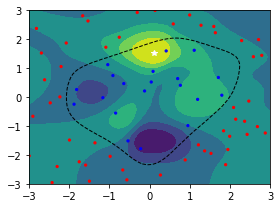

In [13]:
plot_model(api, show_samples=True, show_sol=solution, show_class=True)

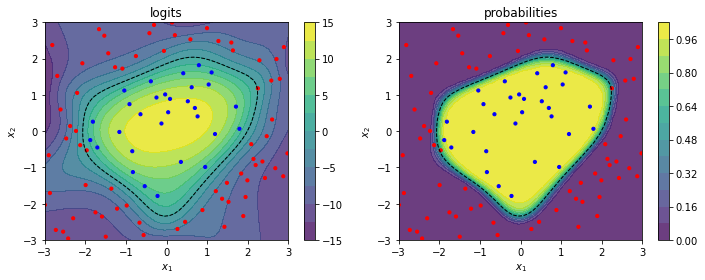

In [14]:
x1, x2 = np.linspace(*api.space_[0], 50), np.linspace(*api.space_[1], 50)
x1grid, x2grid = np.meshgrid(x1, x2)
x_new = np.c_[x1grid.ravel(), x2grid.ravel()]

x_plot = np.c_[x1, x2] * api.x_train_std + api.x_train_mean

logits, probs = api.classifier.predict(x_new, return_proba=True)
logits = logits.reshape(x1grid.shape)
probs = probs.reshape(x1grid.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

c1 = ax1.contourf(x_plot[:, 0], x_plot[:, 1], logits, levels=12, alpha=0.8)
ax1.scatter(api.x[:, 0], api.x[:, 1], s=10, c=api.t, cmap='bwr_r')
ax1.contour(x_plot[:, 0], x_plot[:, 1], logits, levels=[0.0], linestyles='dashed', colors='k', linewidths=1)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.title.set_text('logits')
fig.colorbar(c1, ax=ax1)

c2 = ax2.contourf(x_plot[:, 0], x_plot[:, 1], probs, levels=12, alpha=0.8)
ax2.scatter(api.x[:, 0], api.x[:, 1], s=10, c=api.t, cmap='bwr_r')
ax2.contour(x_plot[:, 0], x_plot[:, 1], probs, levels=[0.5], linestyles='dashed', colors='k', linewidths=1)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.title.set_text('probabilities')
fig.colorbar(c2, ax=ax2)

plt.tight_layout()